['ch_0', 'ch_1', 'ch_2', 'ch_3', 'ch_4', 'ch_5', 'ch_6', 'ch_7', 'ch_8', 'ch_9', 'ch_10', 'ch_11', 'ch_12', 'ch_13', 'ch_14', 'ch_15', 'ch_16', 'ch_17', 'ch_18', 'ch_19', 'ch_20', 'ch_21', 'ch_22', 'ch_23']


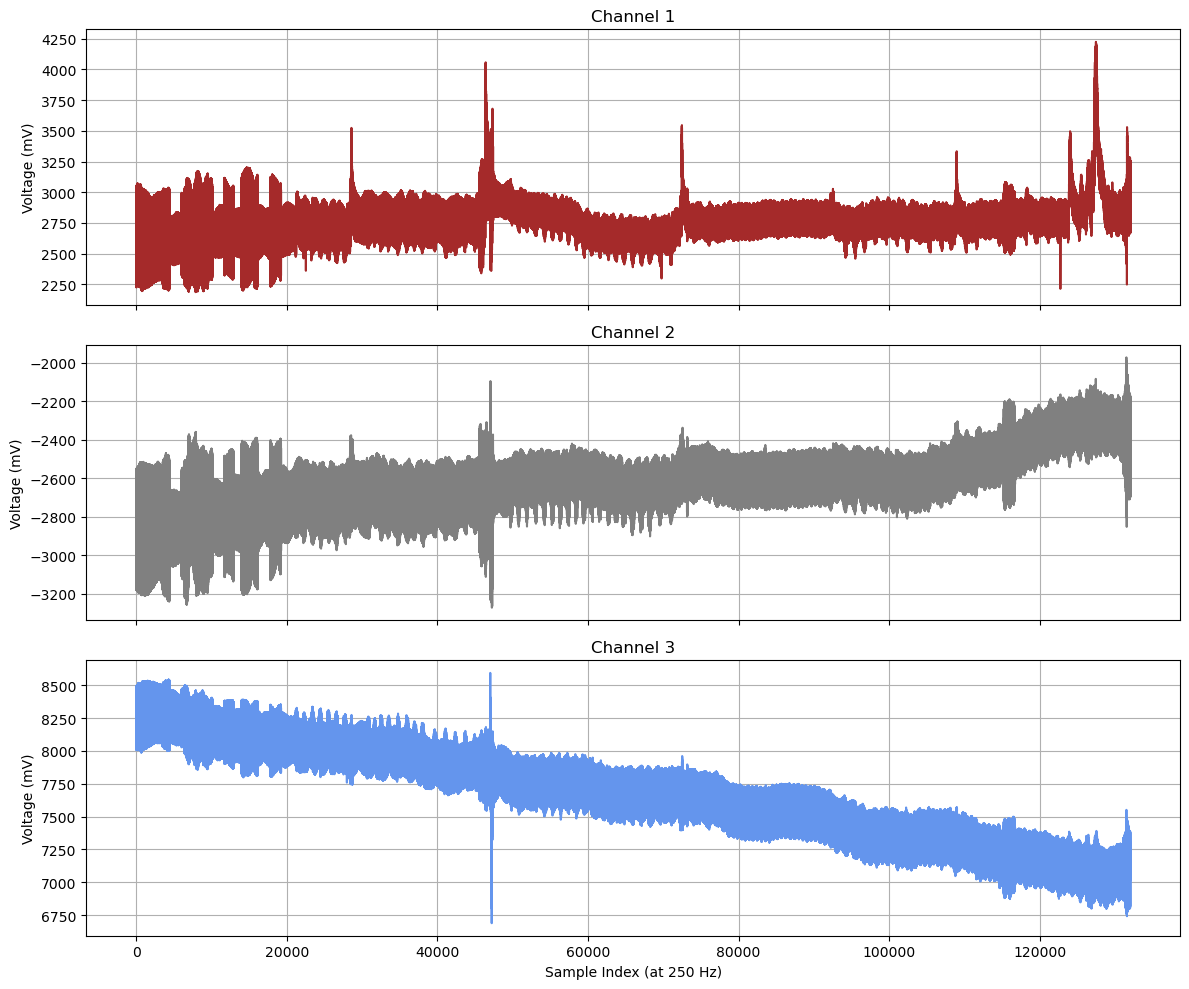

In [2]:
# -------------------------- Visualization of Raw data

import pandas as pd
import matplotlib.pyplot as plt

# Load OpenBCI data
path = "C:/Quick_Disk/tonge_project/data/Recordings2/recording2.csv"
df = pd.read_csv(path, sep='\t', skiprows=5, engine='python')

# Rename columns name for clarity
df.columns = [f"ch_{i}" for i in range(df.shape[1])]
print(df.columns.tolist())

# Define sampling rate and duration
sampling_rate = 250  # Hz
duration_sec = 20
num_samples = df.shape[0] # sampling_rate * duration_sec  # 5000 samples

# Create subplots
channel_colors = {
    'ch_1': 'brown',
    'ch_2': 'gray',
    'ch_3': '#6495ed'
}
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Plot Channel 1
axs[0].plot(df.iloc[:num_samples, 1], color=channel_colors['ch_1'])
axs[0].set_title("Channel 1")
axs[0].set_ylabel("Voltage (mV)")
axs[0].grid(True)

# Plot Channel 2
axs[1].plot(df.iloc[:num_samples, 2], color=channel_colors['ch_2'])
axs[1].set_title("Channel 2")
axs[1].set_ylabel("Voltage (mV)")
axs[1].grid(True)

# Plot Channel 3
axs[2].plot(df.iloc[:num_samples, 3], color=channel_colors['ch_3'])
axs[2].set_title("Channel 3")
axs[2].set_xlabel("Sample Index (at 250 Hz)")
axs[2].set_ylabel("Voltage (mV)")
axs[2].grid(True)

plt.tight_layout()
plt.show()


In [3]:
# -------------------------- Filtering

from scipy.signal import butter, filtfilt
import numpy as np

lowc = 20.0
highc = 120.0

def bandpass_filter(data, lowcut=lowc, highcut=highc, fs=250.0, order=4):
    nyq = 0.5 * fs  # 125 Hz
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

def lowpass_filter(data, cutoff=5.0, fs=250.0, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low')
    return filtfilt(b, a, data)

# Bandpass and Z-score
filtered = {}
for ch in ['ch_1', 'ch_2', 'ch_3']:
    # Bandpass
    raw_filtered = bandpass_filter(df[ch][:num_samples])
    
    # Z-score normalization
    mean = np.mean(raw_filtered)
    std = np.std(raw_filtered)
    zscored = (raw_filtered - mean) / std

    filtered[ch] = zscored

    # Full-wave rectification
    #rectified = np.abs(zscored)
    # Smoothing (low-pass filter)
    #smoothed = lowpass_filter(rectified)
    #filtered[ch] = smoothed


In [18]:
# -------------------------- Windows from the anotations timestamps

import pandas as pd
import numpy as np

# Get annotations
annotations_path = r"C:\Quick_Disk\tonge_project\scripts\data\annotations\annotations2.csv"
annotations = pd.read_csv(annotations_path, header=0, names=['class', 'timestamp'])

# Convert timestamp to numeric (float)
annotations['timestamp'] = pd.to_numeric(annotations['timestamp'], errors='coerce')

print("Annotations head")
print(annotations.head())
print("\nEMG head")
print(df.head())

# Get EMG data
emg_timestamps = df['ch_22']  # Unix timestamps 

# Windows
window_size_seconds = 1.5
windowed_data = {'l': [], 'r': [], 'f': [], 'n': []}  # Dictionary to hold windows by class

for idx, row in annotations.iterrows():
    label = row['class']      # 'l', 'r', 'f', 'n'
    start_time = row['timestamp']
    end_time = start_time + window_size_seconds
    
    # Find indices of samples inside this window
    idxs = (emg_timestamps >= start_time) & (emg_timestamps < end_time)
    
    if not any(idxs):
        # No samples in this window, you can skip or log warning
        print(f"No data for window starting at {start_time} (label={label})")
        continue
    
    # Extract samples for each channel in this window
    window_ch1 = filtered['ch_1'][idxs]
    window_ch2 = filtered['ch_2'][idxs]
    window_ch3 = filtered['ch_3'][idxs]
    
    # Append to dictionary
    windowed_data[label].append({
        'ch_1': window_ch1,
        'ch_2': window_ch2,
        'ch_3': window_ch3,
        'start_time': start_time,
        'end_time': end_time
    })

# Check how many windows per class
print("\nHow many windows per class:")
for c in ['l', 'r', 'f', 'n']:
    print(f"Class '{c}' windows: {len(windowed_data[c])}")

# Double check: how many samples in the first window, should be 250
first_window_l = windowed_data['l'][0]
print("\nNumber of samples in first 'l' window:")
print("ch_1:", len(first_window_l['ch_1']))
print("ch_2:", len(first_window_l['ch_2']))
print("ch_3:", len(first_window_l['ch_3']))


Annotations head
  class     timestamp
0     l  1.749029e+09
1     l  1.749029e+09
2     l  1.749029e+09
3     l  1.749029e+09
4     l  1.749029e+09

EMG head
   ch_0         ch_1         ch_2         ch_3  ch_4  ch_5  ch_6  ch_7  ch_8  \
0   2.0  2642.155009 -2783.462737  8302.421367   0.0   0.0   0.0   0.0   0.0   
1   3.0  3041.871255 -3175.869963  8007.713617   0.0   0.0   0.0   0.0   0.0   
2   4.0  2715.267565 -2999.179423  8157.939691   0.0   0.0   0.0   0.0   0.0   
3   5.0  2248.294920 -2561.442859  8477.770803   0.0   0.0   0.0   0.0   0.0   
4   6.0  2338.864188 -2559.520609  8476.027367   0.0   0.0   0.0   0.0   0.0   

    ch_9  ...  ch_14  ch_15  ch_16  ch_17  ch_18  ch_19  ch_20  ch_21  \
0  0.016  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1  0.016  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2  0.016  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3  0.016  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.

In [19]:
# --------------------------------------  Prepare data for CNN
import numpy as np
from sklearn.model_selection import train_test_split

X = []
y = []
label_map = {'l': 0, 'r': 1, 'f': 2, 'n': 3}
expected_samples = int(sampling_rate * window_size_seconds)

for label, windows in windowed_data.items():
    for window in windows:
        # Stack channels -> shape (3, time_steps)
        ch_stack = np.vstack([window['ch_1'], window['ch_2'], window['ch_3']])
        
        # Ensure fixed-length windows
        if ch_stack.shape[1] >= expected_samples:
            ch_stack = ch_stack[:, :expected_samples]  # Truncate if too long
            X.append(ch_stack)
            y.append(label_map[label])
        else:
            print(f"Discarding short window (length={ch_stack.shape[1]})")

X = np.array(X)  # Shape: (N_samples, 3, time_steps)
y = np.array(y)  # Shape: (N_samples,) 

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# Verify shapes
print("X_train shape:", X_train.shape)  # Should be (N_train, 3, time_steps)
print("y_train shape:", y_train.shape)

X_train shape: (56, 3, 375)
y_train shape: (56,)


In [29]:
# ------------------------------ Build, Train, Evaluate CNN

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

class EMGCNN(nn.Module):
    def __init__(self, n_classes=4, input_shape=(3, 375)):
        super().__init__()
        self.conv1 = nn.Conv1d(3, 16, kernel_size=5)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=3) 
        self.pool = nn.MaxPool1d(2)
        self.dropout = nn.Dropout(0.5)
        
        # Precompute flattened size
        with torch.no_grad():
            x = torch.randn(1, *input_shape)
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = self.pool(F.relu(self.conv3(x)))  
            self.flatten_size = x.view(1, -1).size(1)
        
        self.fc1 = nn.Linear(self.flatten_size, 64)
        self.fc2 = nn.Linear(64, n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))  
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


# Training setup
train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32), 
                         torch.tensor(y_train, dtype=torch.long))  # <-- fix here

test_ds = TensorDataset(torch.tensor(X_test, dtype=torch.float32), 
                        torch.tensor(y_test, dtype=torch.long))   # <-- and here


train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=32)

model = EMGCNN(n_classes=4)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Training loop
for epoch in range(10):
    model.train()
    train_loss = 0.0
    for xb, yb in train_dl:
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    scheduler.step()
    
    # Validation
    model.eval()
    correct, total, val_loss = 0, 0, 0.0
    with torch.no_grad():
        for xb, yb in test_dl:
            preds = model(xb)
            val_loss += criterion(preds, yb).item()
            correct += (preds.argmax(dim=1) == yb).sum().item()
            total += yb.size(0)
    
    print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_dl):.4f}, Val Acc: {correct/total:.2f}")

# Test accuracy
model.eval()
with torch.no_grad():
    correct = sum((model(xb).argmax(dim=1) == yb).sum().item() for xb, yb in test_dl)
print("Final Test Accuracy:", correct / len(test_ds))


Epoch 1, Train Loss: 1.4487, Val Acc: 0.25
Epoch 2, Train Loss: 1.3758, Val Acc: 0.29
Epoch 3, Train Loss: 1.3721, Val Acc: 0.42
Epoch 4, Train Loss: 1.3662, Val Acc: 0.58
Epoch 5, Train Loss: 1.3478, Val Acc: 0.58
Epoch 6, Train Loss: 1.3365, Val Acc: 0.54
Epoch 7, Train Loss: 1.3294, Val Acc: 0.54
Epoch 8, Train Loss: 1.3278, Val Acc: 0.50
Epoch 9, Train Loss: 1.3215, Val Acc: 0.50
Epoch 10, Train Loss: 1.3170, Val Acc: 0.46
Final Test Accuracy: 0.4583333333333333


In [1]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split

X = []
y = []
label_map = {'l': 0, 'r': 1, 'f': 2, 'n': 3}
expected_samples = int(sampling_rate * window_size_seconds)

for label, windows in windowed_data.items():
    for window in windows:
        # Stack channels -> shape (3, time_steps)
        ch_stack = np.vstack([window['ch_1'], window['ch_2'], window['ch_3']])
        
        # Ensure fixed-length windows
        if ch_stack.shape[1] >= expected_samples:
            ch_stack = ch_stack[:, :expected_samples]  # Truncate if too long
            X.append(ch_stack)
            y.append(label_map[label])
        else:
            print(f"Discarding short window (length={ch_stack.shape[1]})")

X = np.array(X)  # Shape: (N_samples, 3, time_steps)
y = np.array(y)  # Shape: (N_samples,) 

# Split into train/test
#X_train, X_test, y_train, y_test = train_test_split(
 #   X, y, test_size=0.3, random_state=42, stratify=y)

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define your model
class EMGCNN(nn.Module):
    def __init__(self, n_classes=4, input_shape=(3, 375)):
        super().__init__()
        self.conv1 = nn.Conv1d(3, 16, kernel_size=5)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5)
        self.pool = nn.MaxPool1d(2)
        self.dropout = nn.Dropout(0.5)

        # Calculate flatten size
        with torch.no_grad():
            x = torch.randn(1, *input_shape)
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            self.flatten_size = x.view(1, -1).size(1)

        self.fc1 = nn.Linear(self.flatten_size, 64)
        self.fc2 = nn.Linear(64, n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# Convert your full dataset to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Define number of folds
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_accuracies = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\n--- Fold {fold + 1}/{n_splits} ---")

    # Split data
    X_train, X_val = X_tensor[train_idx], X_tensor[val_idx]
    y_train, y_val = y_tensor[train_idx], y_tensor[val_idx]

    # Create DataLoaders
    train_ds = TensorDataset(X_train, y_train)
    val_ds = TensorDataset(X_val, y_val)

    train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=16)

    # New model per fold
    model = EMGCNN(n_classes=4)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    # Train
    for epoch in range(10):
        model.train()
        for xb, yb in train_dl:
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

    # Validate
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in val_dl:
            preds = model(xb)
            correct += (preds.argmax(dim=1) == yb).sum().item()
            total += yb.size(0)

    acc = correct / total
    fold_accuracies.append(acc)
    print(f"Fold {fold+1} Accuracy: {acc:.2f}")

# Final results
print(f"\nAverage Accuracy across {n_splits} folds: {np.mean(fold_accuracies):.2f}")


NameError: name 'sampling_rate' is not defined